# Investigations & Data Science Journalism using Graphistry over OSINT data
_________________________________________________________________________

Explore Data from the anti-corruption site https://chavismoinc.com as a Data Science Journalist!

Graphistry makes OSINT data easy to explore. We demonstrate with Chavismo's data, gotten from court cases, inditments, DoJ and journalistic investigations of powerfully connected individuals and entities. 

You will learn:
* How to create graphs using the explicit edge relationships from this data
* How to featurize the data 
* How to create subgraphs from natural language querying

Make a copy of this notebook and test it on your favorite corpus! 


______________________________________________
Make sure you pip install graphistry[ai] and sign up for a free GPU accelerated HUB account: hub.graphistry.com

In [1]:
#! pip install --upgrade graphistry[ai]

In [3]:
import graphistry
from graphistry.features import ModelDict, topic_model, search_model, qa_model

import requests
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)

np.random.seed(137)

In [4]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username=os.environ['USERNAME'], password=os.environ['GRAPHISTRY_PASSWORD'])

In [5]:
# make sure you have a `data` folder
# mkdir data

# Get the data

In [6]:
# download the data
def download_chavismo_data(get_fresh=True): # set to false to load the save instance
    if get_fresh:
        url = "https://chavismoinc.com/backend/word-press-site/exportar?lang=en"
        r = requests.get(url, allow_redirects=True)
        filename = f"chavismo.xlsx"
        open(filename, "wb").write(r.content)
        df = pd.read_excel(filename)
        df.to_csv("chavismo.csv", header=True)
    else:
        df = pd.read_csv('chavismo.csv', index_col=0)
    return df

df = download_chavismo_data(get_fresh=False)  # set to True to get latest data
df

,Agent 1,Relationship,Agent 2,Source,Evidence
0,Abdala Makled García (Venezuela),Complaints for corruption,Fundación Makled C.A. (Venezuela),Court document,The foundation received complaints for being the social arm of Walid Makled and his group of companies. It gave six million Bolivares fuertes to the Carabobo State Executive.
1,Abdiel Cano & Asociados (Venezuela),Facilitators,Eduardo Manuitt Carpio (Venezuela),Official document,Resident agent of societies linked to Panama.
2,Abraham Edgardo Ortega (Venezuela),Occupied functions,Ministry of People´s Power for Oil and Mining (Venezuela),Official document,Member of Strategic Commitee of Execution. Official Gazette 40.077 of December 21st 2012.
3,Abraham Edgardo Ortega (Venezuela),International trials. Money laundering. Bribery. Illegal Currency traffic,"Petróleos de Venezuela S.A. (Pdvsa) (Venezuela, USA, Colombia, Germany, Portugal)",Court document,"Federal Tribunal of South Florida district investigates alleged crimes such as money laundering, bribery and false loan in Pdvsa."
4,Abraham José Shiera Bastidas (Venezuela),International trials. Money laundering. Bribery.,"Petróleos de Venezuela S.A. (Pdvsa) (Venezuela, USA, Colombia, Germany, Portugal)",Court document,"A Federal Tribunal of Houston investigates alleged crimes of conspiration to violate the law of corrupt practices abroad, money laundering and false tax declarations."
...,...,...,...,...,...
2713,Joaquín De Grazia (Argentina),Integrates Company,Granja Tres Arroyos (Argentina),Recognized communication media (trustable),President of the Company
2714,Carlos Mario Piano (Argentina),Company connection,Granja Tres Arroyos (Argentina),Recognized communication media (trustable),Representative.
2715,Egly Antonio Ramírez Coronado (Venezuela),Occupied functions,"Pdvsa Agrícola, S.A. (Venezuela)",Recognized communication media (trustable),"President. Official Gazzette 38.923 of May 05th, 2008."
2716,Sancor Cooperativas Unidas (Argentina),International trials. Overpricing,"Petróleos de Venezuela S.A. (Pdvsa) (Venezuela, USA, Colombia, Germany, Portugal)",Recognized communication media (trustable),"National Auditing Office report, Argentina"


In [7]:
print(f"Number of distinct Agent-1s: {df['Agent 1'].nunique()}")

Number of distinct Agent-1s: 799


In [8]:
print(f"Number of distinct Agent-2s: {df['Agent 2'].nunique()}")

Number of distinct Agent-2s: 1013


In [9]:
print(f"Number of distinct relationships: {df['Relationship'].nunique()}")

Number of distinct relationships: 68


# Create a graph of Interactions between people and entities

* shows a web of connections between `Agents`
* a huge collection of people involving families, banks, military, and judicial offices as well as other cartels

In [10]:
RENDER = True # set to True to have plots generated inline, or paste the URLs into a tab to see the graphs

In [11]:
g = graphistry.nodes(df, 'Agent 1').edges(df, 'Agent 1', 'Agent 2')
g.plot(render=RENDER)

In [12]:
# Create a hypergraph with any number of columns of interest
hg = graphistry.hypergraph(df, ['Agent 1','Agent 2', 'Relationship'])
gh = hg['graph']
gh.bind(point_title='nodeID').plot(render=RENDER)

# links 8154
# events 2718
# attrib entities 1880


# Featurize the Data to make it Searchable 

In [13]:
#g.featurize?  #for information about the featurize API

In [14]:
search_model.update(dict(cardinality_threshold_target=2, n_topics_target=11))
search_model

_____________________________________________________________

sentence-transformers/msmarco-distilbert-base-v2 Search Model
_____________________________________________________________

Updated: {'cardinality_threshold_target': 2, 'n_topics_target': 11}
_____________________________________________________________



{'min_words': 0, 'model_name': 'sentence-transformers/msmarco-distilbert-base-v2', 'cardinality_threshold_target': 2, 'n_topics_target': 11}

In [15]:
%%time

model = ModelDict('Search model over features with `y=Relationship` topic model', y=['Relationship'], 
                 **search_model)
process = True
if process:
    g = graphistry.nodes(df.sample(len(df)), 'Agent 1').edges(df, 'Agent 1', 'Agent 2')

    # since we have edges, let's featurize (rather than umap, which would overwrite explicit edges)
    # X = None will featurize ALL the columns and setting min_words=0 will treat them all as textual
    g2 = g.featurize(**model)
    g2.save_search_instance('chavismo.search')
else:
    g2 = graphistry.bind().load_search_instance('chavismo.search')
    
model

CPU times: user 2min 35s, sys: 9.96 s, total: 2min 45s
Wall time: 2min 27s
____________________________________________________________

Search model over features with `y=Relationship` topic model
____________________________________________________________



{'y': ['Relationship'], 'min_words': 0, 'model_name': 'sentence-transformers/msmarco-distilbert-base-v2', 'cardinality_threshold_target': 2, 'n_topics_target': 11}

In [16]:
# the resulting X = features matrix, sbert encoding
X = g2.get_matrix()
X

,Agent 2_Source_Evidence_0,Agent 2_Source_Evidence_1,Agent 2_Source_Evidence_2,Agent 2_Source_Evidence_3,Agent 2_Source_Evidence_4,Agent 2_Source_Evidence_5,Agent 2_Source_Evidence_6,Agent 2_Source_Evidence_7,Agent 2_Source_Evidence_8,Agent 2_Source_Evidence_9,...,Agent 2_Source_Evidence_758,Agent 2_Source_Evidence_759,Agent 2_Source_Evidence_760,Agent 2_Source_Evidence_761,Agent 2_Source_Evidence_762,Agent 2_Source_Evidence_763,Agent 2_Source_Evidence_764,Agent 2_Source_Evidence_765,Agent 2_Source_Evidence_766,Agent 2_Source_Evidence_767
1935,-0.187781,-0.387294,-0.160111,0.533505,-0.012384,-0.036983,-0.227363,0.305134,-0.053135,0.242913,...,0.295774,0.358959,0.566532,-0.852727,0.118316,-0.122535,0.347825,0.101922,0.386412,-0.644331
1583,-0.389066,-0.087771,-0.775325,0.130028,0.172289,-0.208622,-0.874529,0.382446,0.483579,-0.309687,...,0.152333,-0.175365,0.676532,-0.393536,0.014875,-0.383976,0.081081,0.298928,0.596412,-0.605296
2351,-0.423137,0.182216,-0.133435,0.217782,-0.094416,-0.097829,-0.876501,0.797395,-0.277968,-0.045989,...,1.015161,0.453668,0.440656,-0.040266,0.693482,0.169744,0.060993,-0.500294,0.649334,0.195239
452,-0.095392,0.142223,-0.686644,0.674334,-0.228214,0.109001,-0.440772,0.124842,-0.066046,0.171612,...,-0.009296,0.564043,0.178982,-0.222556,0.523386,0.331242,0.360143,-0.011475,0.105367,0.146013
8,-0.477632,-0.784202,-0.383131,0.669990,-0.100068,-0.294655,-0.627293,0.058967,-0.455835,0.461948,...,0.381159,0.021592,0.348291,-0.903526,0.694809,0.018819,-0.002837,0.023364,0.385524,-0.437104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,-0.593350,0.112945,0.123807,0.948721,-0.276408,-0.603181,-0.392917,0.388957,0.126814,1.126764,...,-0.089558,-0.331218,0.120006,-0.712097,-0.205538,0.562405,0.525867,-0.204776,-0.197538,-0.018287
1264,0.476763,0.199641,0.226375,0.824276,-0.438520,-0.420465,0.386475,0.275413,-0.350755,0.047801,...,0.755453,0.358454,0.348341,-1.133082,-0.210484,-0.764606,0.916726,-0.284010,-0.056577,0.407399
1171,-0.270009,0.170292,0.052011,0.060369,-0.265923,0.717389,-0.561747,0.256904,0.061957,0.049001,...,-0.322604,-0.409145,0.270570,-0.290132,0.037762,0.646035,-0.226534,0.178052,0.890680,-0.204422
589,0.217439,0.188192,-0.186874,0.108394,0.318829,0.049164,-0.460243,0.502261,-0.304636,0.176173,...,0.700581,0.730317,0.152944,0.017145,0.597685,0.536023,-0.020815,-0.774539,0.354638,0.153618


In [17]:
# we've reorganized 68 relationships into N topics and we see it has understood the semantics correctly
y = g2.get_matrix(target=True)
y

,"Relationship: occupied, functions, sanctions","Relationship: laundering, overpricing, international","Relationship: integrates, company, in","Relationship: complaints, corruption, traffic","Relationship: sanctioned, sanction, evasion","Relationship: facilitators, colleagues, student","Relationship: designates, charge, rights","Relationship: connection, business, in","Relationship: members, family, enemies","Relationship: smuggling, bribery, currency","Relationship: conspiracy, suscribed, contract"
1935,0.072898,0.553233,0.089311,0.068496,0.075216,0.058883,0.059063,0.091499,0.067527,42.147305,42.766569
1583,23.982221,0.053704,0.050000,0.055351,0.090587,0.050000,0.050001,0.062470,0.050000,0.052716,0.052951
2351,23.982221,0.053704,0.050000,0.055351,0.090587,0.050000,0.050001,0.062470,0.050000,0.052716,0.052951
452,23.982221,0.053704,0.050000,0.055351,0.090587,0.050000,0.050001,0.062470,0.050000,0.052716,0.052951
8,0.072986,0.053850,0.051025,0.053534,16.497892,0.050000,0.050001,0.065366,0.050000,0.053286,0.052058
...,...,...,...,...,...,...,...,...,...,...,...
334,0.072986,0.053850,0.051025,0.053534,16.497892,0.050000,0.050001,0.065366,0.050000,0.053286,0.052058
1264,0.072986,0.053850,0.051025,0.053534,16.497892,0.050000,0.050001,0.065366,0.050000,0.053286,0.052058
1171,0.050000,0.051786,0.050000,0.050037,0.050001,0.054220,0.050000,0.050705,18.039779,0.052556,0.050917
589,0.050000,0.053772,23.990746,0.059230,0.051608,0.052662,0.060380,0.072165,0.050000,0.053006,0.056433


<AxesSubplot:ylabel='Frequency'>

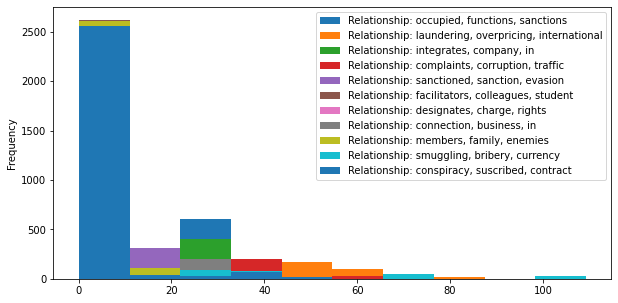

In [18]:
y.plot(kind='hist', figsize=(10,5))  

In [19]:
g2._nodes['rel_topic'] = [y.columns[k].replace('Relationship: ', '') for k in y.values.argmax(1)]

In [20]:
g2._nodes['rel_topic']

1935    conspiracy, suscribed, contract
1583     occupied, functions, sanctions
2351     occupied, functions, sanctions
452      occupied, functions, sanctions
8         sanctioned, sanction, evasion
                     ...               
334       sanctioned, sanction, evasion
1264      sanctioned, sanction, evasion
1171           members, family, enemies
589             integrates, company, in
2342      sanctioned, sanction, evasion
Name: rel_topic, Length: 2718, dtype: object

In [21]:
g2 = g2.nodes(g2._nodes, g2._node)

# Search the graph

In [22]:
res, query_vector = g2.search('money laundering', top_n=5)
res.rel_topic

2498              smuggling, bribery, currency
2497              smuggling, bribery, currency
2482                  connection, business, in
1744    laundering, overpricing, international
2487                  connection, business, in
Name: rel_topic, dtype: object

## Search to Graph

Pull in neighborhood data from a given search
* the resulting graph will contain Agents connected to Agents that have been involved in Money Laundering (or whatever you wish to search for)
* it is a good way to filter down the main graph to the relevant players given a natural language search

In [23]:
# search to graph 
g2.search_graph('money laundering', top_n=20).bind(point_title='Agent 1').plot(render=RENDER)

In [24]:
res, _ = g2.search('drug trafficking', top_n=5)
res

,Agent 1,Relationship,Agent 2,Source,Evidence,rel_topic,_distance
2233,Tareck Zaidan El Aissami Maddah (Venezuela),Complaints for corruption. Drug Traffic,Hermágoras González Polanco (Colombia),Recognized communication media (trustable),"Colombian druf trafficker, leader of Guajira Cartel, according to the Narcogram, he is linked to Tareck El Aissami.","complaints, corruption, traffic",13.883661
108,Alex Nain Saab Morán (Colombia),International trials. Money laundering. Fraud,Robinson Ruíz Guerrero (Colombia),Recognized communication media (trustable),"79th Court of Guarantee control of Colombia investigates money laundering, conspiracy to commit a crime, illicit enrichment, fake export or import and aggravated scam.","laundering, overpricing, international",13.998826
111,Alex Nain Saab Morán (Colombia),International trials. Money laundering. Fraud,Luis Alberto Saab Morán (Colombia),Recognized communication media (trustable),"79th Court of Guarantee control of Colombia investigates money laundering, conspiracy to commit a crime, illicit enrichment, fake export or import and aggravated scam.","laundering, overpricing, international",14.068014
668,Ditter José Marcano (Venezuela),Complaints for corruption. Drug Traffic,Jaime Alberto Marín Zamora (Colombia),Recognized communication media (trustable),"Denounces links between drug lords, scam groups, money laundering and a network of SAIME offices. Ditter José Marcano was pointed.","complaints, corruption, traffic",14.180918
110,Alex Nain Saab Morán (Colombia),International trials. Money laundering. Fraud,Amir Luis Saab Morán (Colombia),Recognized communication media (trustable),"79th Court of Guarantee control of Colombia investigates money laundering, conspiracy to commit a crime, illicit enrichment, fake export or import and aggravated scam.","laundering, overpricing, international",14.181194


In [25]:
g2.search_graph('drug trafficking court documents').bind(point_title='Agent 1').plot(render=RENDER)

In [26]:
res, _  = g2.search('military officials', top_n=3)
res[['Agent 1', 'Relationship', 'Evidence']]

,Agent 1,Relationship,Evidence
1384,Katherine Nayartih Haringhton Padrón (Venezuela),Sanctioned by,"The only non military officer included on the decree 03/09/2015, in which President Barack Obama suspended visas and froze assets of government officials, for Human Rights violation."
1265,José Miguel Montoanda Rodríguez (Venezuela),Sanctioned by,"Included him on the list of sanctioned officials for being ""responsibles or accomplices of serious violations"" to Human Rights, ""important acts of corruption or both""."
2363,Xavier Antonio Moreno Reandes (Venezuela),Sanctioned by,"On June 25th, 2018 the European Union included him on the list of 11 officials sanctioned"


In [27]:
res, _ = g2.search('who is in the ministry of energy?')
res[['Agent 1', 'Evidence']]

,Agent 1,Evidence
482,Carmen Cecilia Molina Díaz (Venezuela),"Director of the Administrative and Financial Management Unit of the Sectoral Vice - Presidency of Public Works and Services. Published in Official Gazzette 41.182 on June 28th, 2017."
1364,July César Izquierdo Rodríguez (Venezuela),"General Director of Information and Sectoral Indicators (in charge), of the Sectoral Vice - Presidency of Public Works and Services. Official Gazzette 41.182 of June 28th, 2017."
1165,Javier Andrés Alvarado Ochoa (Venezuela),"National Audience and Anti - corruption Prosecutor of Spain investigates alleged bribery and money laundering. Involved: Ministry of Energy and Mining , CORPOELEC."
1330,Juan Carlos Torres Inclán (Spain),"National Audience and Anti - corruption Prosecutor of Spain investigates alleged bribery and money laundering. Involved: Ministry of Energy and Mining , CORPOELEC."
676,Duro Felguera (Spain),"National Audience and the Anti - Corruption Prosecutor of Spain investigate alleged bribery and money laundering. Involved: Ministry of Energy and Mining , CORPOELEC."
2252,Técnicas Reunidas Terca Ca (Venezuela),"National Audience and Anti - corruption Prosecutor of Spain investigates alleged bribery and money laundering. Involved Ministry of Energy and Mining , CORPOELEC."
1468,Luís Barrios Melean (No information available),"National Audience and Anti - corruption Prosecutor of Spain investigates alleged bribery and money laundering. Involved Ministry of Energy and Mining , CORPOELEC."
1126,"Ingeniería Gestión de Proyectos de Energía, C.A. (Ingespre) (No information available)","National Audience and Anti - corruption Prosecutor of Spain investigates alleged bribery and money laundering. Involved Ministry of Energy and Mining , CORPOELEC."
2283,Víctor Eduardo Aular Blanco (Venezuela),"Member of the Strategic Execution Committee of the Financial area. Official Gazzette 39.182, May 20th, 2009."
360,Carlos Eduardo Borges Polar (Venezuela),"Director of the Internal Operations Office (in charge), of the Sectoral Vice - Presidency of Public Works and Services. Official Gazzette 41.182 of June 28th, 2017."


In [28]:
g2.search_graph('who is in the ministry of energy?').plot(render=RENDER)

In [29]:
g2.search_graph('drug trafficking').dbscan().plot(render=RENDER)

In [32]:
g2.search_graph('banks used to funnel money').plot(render=RENDER)

In [33]:
g2.search_graph('oil and energy companies').plot(render=RENDER)

# Contributions

Data Science Journalism meets Graph Intelligence!
* Quickly load your data and see the relationships present
* Search Semantically and Create Subgraphs from Search
* Color by properties and create compelling data stories

Join the Graphistry-Community Slack! 
